In [406]:
# ------------------------------------
# 1. Core Data Manipulation & Visualization
# ------------------------------------
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# ------------------------------------
# 2. Text Processing (NLP)
# ------------------------------------
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

# ------------------------------------
# 3. Feature Engineering & Preprocessing
# ------------------------------------
from scipy.sparse import hstack, csr_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# ------------------------------------
# 4. Machine Learning Models
# ------------------------------------
from sklearn.naive_bayes import BernoulliNB

# ------------------------------------
# 5. Model Evaluation Metrics
# ------------------------------------
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.metrics import accuracy_score, recall_score

from imblearn.over_sampling import SMOTE
from collections import Counter

In [407]:
df = pd.read_csv('spam.csv',encoding='latin-1')
df.sample(5)

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
4306,ham,I guess it is useless calling u 4 something im...,NaN,NaN,NaN
1105,ham,on hen night. Going with a swing,NaN,NaN,NaN
447,ham,I wont get concentration dear you know you are...,NaN,NaN,NaN
1381,ham,We spend our days waiting for the ideal path t...,NaN,NaN,NaN
1490,ham,Cant believe i said so many things to you this...,NaN,NaN,NaN


In [408]:
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)
df.rename(columns={'v1': 'label', 'v2': 'message'}, inplace=True)

df.sample(5)

,label,message
1060,ham,I'm working technical support :)voice process....
5282,ham,I have gone into get info bt dont know what to do
4165,ham,Well if I'm that desperate I'll just call arma...
3680,ham,LOL what happens in Vegas stays in vegas
2727,ham,Whatsup there. Dont u want to sleep


In [409]:
df.groupby('label').describe()

message                                                               
        count unique                                                top freq
label                                                                       
ham      4825   4516                             Sorry, I'll call later   30
spam      747    653  Please call our customer service representativ...    4

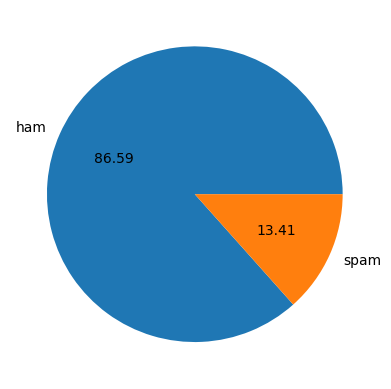

In [410]:
plt.pie(df['label'].value_counts(), labels=['ham','spam'],autopct="%0.2f")
plt.show()



In [411]:
lb = LabelEncoder()
df['label'] = lb.fit_transform(df['label'])
df.sample(5)

,label,message
4743,0,"\Thinking of u ;) x\"""""
4624,0,I'm on the bus. Love you
193,0,It will stop on itself. I however suggest she ...
3567,0,Sent me de webadres for geting salary slip
1646,0,Thts wat Wright Brother did to fly..


In [412]:
# check for duplicate values
df.duplicated().sum()

np.int64(403)

In [413]:
df.drop_duplicates(keep='first', inplace=True)

In [414]:
df.shape

(5169, 2)

Spam doesn't just differ from ham by a single word;
it's the frequency of certain words,
the structure of the email, the presence of specific symbols or links, etc.

So We will need to create additional columns to avoid the problem of under-fitting
Cuz we just have 2 columns

So we will add columns such as number of tokens, Characters Count,...

In [415]:
nltk.download('stopwords')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\dell\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [416]:
df['tokens_count'] = df['message'].apply(lambda x: len(nltk.word_tokenize(x)))
df['char_count'] = df['message'].apply(len)
df['caps_ratio'] = df['message'].apply(lambda x: sum(1 for c in x if c.isupper()) / (len(x) + 1e-6))
df['num_dollar_sign'] = df['message'].apply(lambda x: x.count('$'))
df['has_url'] = df['message'].apply(lambda x: 1 if re.search(r'http[s]?://', x) else 0)

In [417]:
df.sample(5)

,label,message,tokens_count,char_count,caps_ratio,num_dollar_sign,has_url
2545,0,So are you guys asking that i get that slipper...,17,80,0.012500,0,0
2596,0,No i'm not gonna be able to. || too late notic...,31,109,0.009174,0,0
3596,1,Congratulations YOU'VE Won. You're a Winner in...,24,115,0.156522,0,0
1432,0,Thanks for ve lovely wisheds. You rock,8,38,0.052632,0,0
4768,0,watever reLation u built up in dis world only ...,23,120,0.008333,0,0


In [418]:
df.groupby('label').describe()

tokens_count                                                      \
             count       mean        std  min   25%   50%   75%    max   
label                                                                    
0           4516.0  17.123782  13.493970  1.0   8.0  13.0  22.0  220.0   
1            653.0  27.667688   7.008418  2.0  25.0  29.0  32.0   46.0   

      char_count              ... num_dollar_sign      has_url            \
           count        mean  ...             75%  max   count      mean   
label                         ...                                          
0         4516.0   70.459256  ...             0.0  3.0  4516.0  0.000000   
1          653.0  137.891271  ...             0.0  1.0   653.0  0.027565   

                                          
            std  min  25%  50%  75%  max  
label                                     
0      0.000000  0.0  0.0  0.0  0.0  0.0  
1      0.163849  0.0  0.0  0.0  0.0  1.0  

[2 rows x 40 columns]

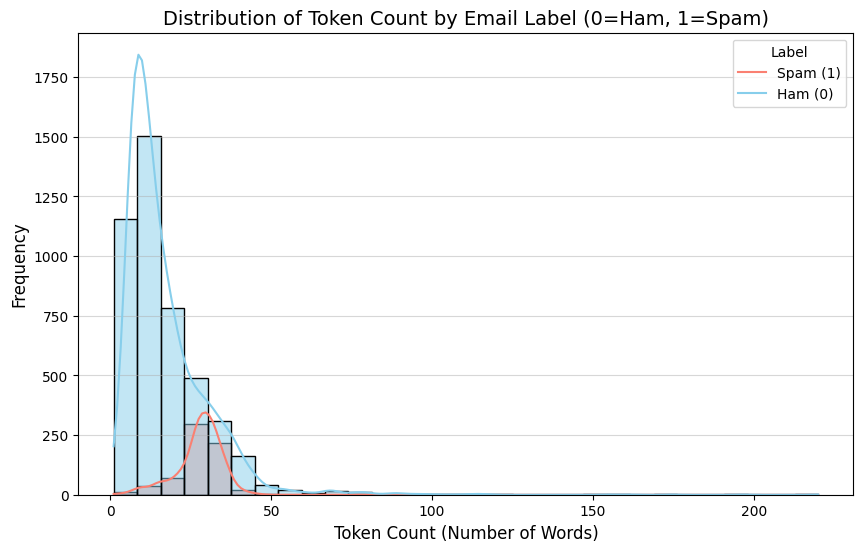

In [419]:

# --- 1. Histogram for Tokens Count per Label ---
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='tokens_count', hue='label', kde=True, bins=30, palette={0: 'skyblue', 1: 'salmon'})
plt.title('Distribution of Token Count by Email Label (0=Ham, 1=Spam)', fontsize=14)
plt.xlabel('Token Count (Number of Words)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(title='Label', labels=['Spam (1)', 'Ham (0)'])
plt.grid(axis='y', alpha=0.5)


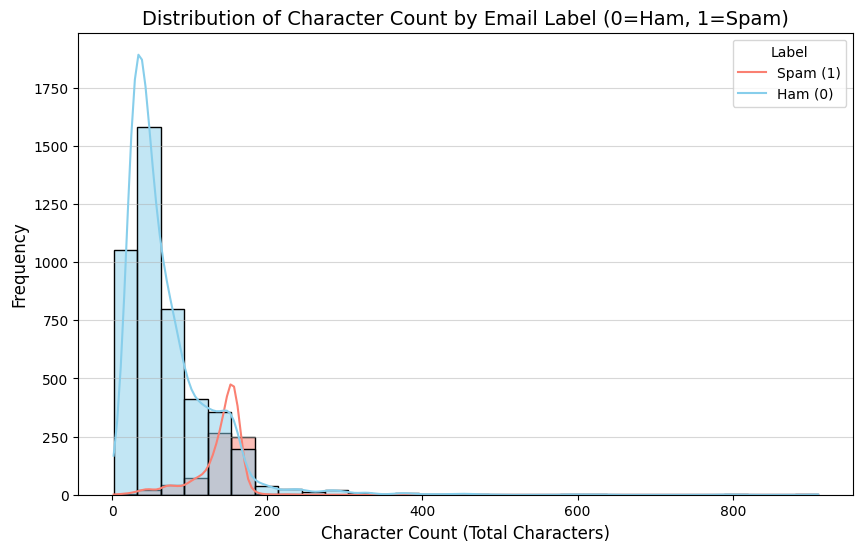

In [420]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='char_count', hue='label', kde=True, bins=30, palette={0: 'skyblue', 1: 'salmon'})
plt.title('Distribution of Character Count by Email Label (0=Ham, 1=Spam)', fontsize=14)
plt.xlabel('Character Count (Total Characters)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.legend(title='Label', labels=['Spam (1)', 'Ham (0)'])
plt.grid(axis='y', alpha=0.5)

In [421]:
def clean_text(text):
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # tokenization 
    tokens = nltk.word_tokenize(text)
    #Remove stopwords (requires NLTK)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    return " ".join(tokens)

# Example usage:
df['clean_message'] = df['message'].apply(clean_text)

In [422]:
df.drop('message', axis=1, inplace=True)
df.sample(5)

,label,tokens_count,char_count,caps_ratio,num_dollar_sign,has_url,clean_message
1327,1,32,126,0.095238,0,0,ur balance å£ ur next question sang uptown gir...
749,0,10,42,0.047619,0,0,monday next week give full gist
3634,0,46,191,0.015707,0,0,make cry stuff happens top everything else pus...
3758,0,15,67,0.149254,0,0,god asked forgiveness little child gave lovely...
4030,0,17,84,0.023810,0,0,sorry vikky im watching olave mandara movie ka...


In [423]:
stemmer = SnowballStemmer("english")

In [424]:
df['clean_message'] = df['clean_message'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))

In [425]:
df.sample(5)

,label,tokens_count,char_count,caps_ratio,num_dollar_sign,has_url,clean_message
4462,0,22,85,0.023529,0,0,said look pretti wif long hair wat thk hes cut...
2826,0,37,149,0.013423,0,0,oh right ok ill make sure load work day got re...
4544,0,22,78,0.064103,0,0,never lei v lazi got wat dat day ì send da url...
3944,0,13,60,0.033333,0,0,gentl princess make sweet gentl love
2926,0,7,25,0.080000,0,0,ok u enjoy ur show


In [426]:
wc = WordCloud(width=500,height=500,min_font_size=10,background_color='white')

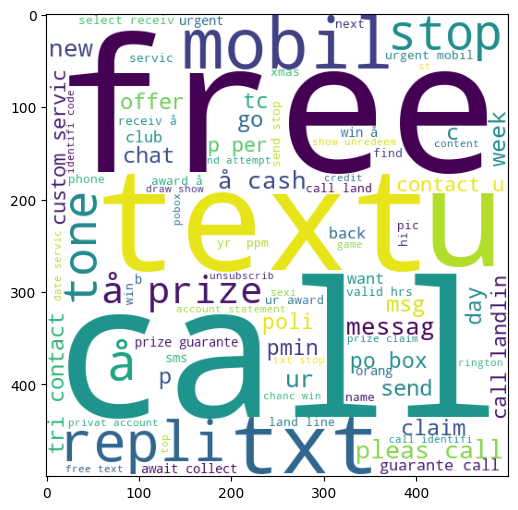

In [427]:
spam_wc = wc.generate(df[df['label'] == 1]['clean_message'].str.cat(sep=" "))
plt.figure(figsize=(10,6))
plt.imshow(spam_wc)

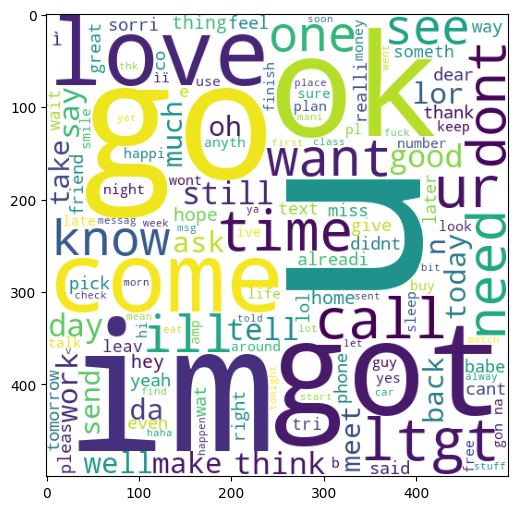

In [428]:
spam_wc = wc.generate(df[df['label'] == 0]['clean_message'].str.cat(sep=" "))
plt.figure(figsize=(10,6))
plt.imshow(spam_wc)

In [429]:
# tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
tfidf_vectorizer = TfidfVectorizer(max_features=2000)

In [430]:
X = tfidf_vectorizer.fit_transform(df['clean_message']).toarray()

In [431]:
X.shape

(5169, 2000)

In [432]:
# appending the num_character col to X
manual_features = df[['char_count', 'tokens_count','caps_ratio','num_dollar_sign','has_url']]

# Convert manual features to sparse matrix (matching the sparse X_text format)
manual_features_sparse = csr_matrix(manual_features.values)

X_final = hstack([X, manual_features_sparse])

In [433]:
X_final.shape

(5169, 2005)

In [434]:
y = df['label'].values

In [435]:
smote = SMOTE(sampling_strategy='minority',random_state=42)
X_sm, y_sm = smote.fit_resample(X_final, y)


In [436]:
print("Original Training Set Distribution: %s" % Counter(y))
print("SMOTE Training Set Distribution: %s" % Counter(y_sm))

Original Training Set Distribution: Counter({np.int64(0): 4516, np.int64(1): 653})
SMOTE Training Set Distribution: Counter({np.int64(0): 4516, np.int64(1): 4516})


In [437]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X_sm.toarray())

In [438]:
X_train,X_test,y_train,y_test = train_test_split(X,y_sm,test_size=0.2,random_state=42, stratify=y_sm)

In [439]:
bnb = BernoulliNB()

In [440]:
bnb.fit(X_train,y_train)
y_pred = bnb.predict(X_test)

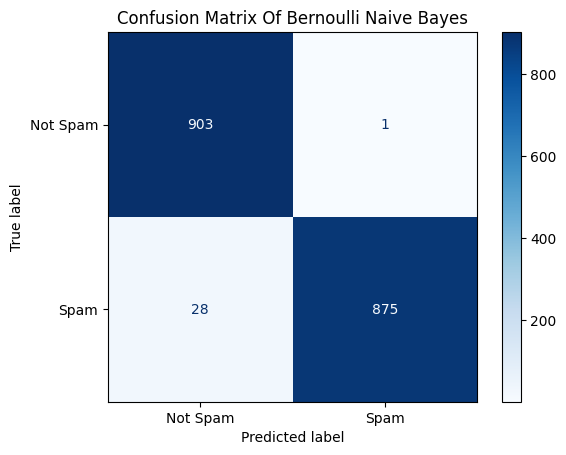

In [ ]:
cm = confusion_matrix(y_test, y_pred)
# Initialize the display using the calculated matrix
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=['Not Spam', 'Spam']
)

# Plot the matrix
disp.plot(cmap=plt.cm.Blues) 

# Add a title and show the plot
plt.title('Confusion Matrix Of Bernoulli Naive Bayes')
plt.show()

In [442]:
accuracy, recall = accuracy_score(y_test, y_pred), recall_score(y_test, y_pred)

print(f"\nBNB Test Accuracy: {accuracy:.4f}")
print(f"BNB Test Recall: {recall:.4f}")

print("BNB Classification Report:")
print(classification_report(y_pred,y_test))


BNB Test Accuracy: 0.9840
BNB Test Recall: 0.9690
BNB Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98       931
           1       0.97      1.00      0.98       876

    accuracy                           0.98      1807
   macro avg       0.98      0.98      0.98      1807
weighted avg       0.98      0.98      0.98      1807



In [ ]:
def preprocess_for_predict(new_messages, tfidf_vectorizer, scaler):
    """
    Applies the exact same feature engineering and scaling steps
    to new, unseen messages for model prediction.

    Args:
        new_messages (list or pd.Series): A list or Series of raw email strings.
        tfidf_vectorizer: The TfidfVectorizer object fitted on the training data.
        scaler: The MinMaxScaler object fitted on the training data.

    Returns:
        numpy.ndarray: The final, scaled feature array ready for model.predict().
    """
    
    if isinstance(new_messages, str):
        # Handle single string input by wrapping it in a list/Series
        new_messages = pd.Series([new_messages])

    # Create a temporary DataFrame for feature calculation
    temp_df = pd.DataFrame({'message': new_messages})
    
    # 1. Feature Engineering (Must be calculated on the raw message)
    temp_df['tokens_count'] = temp_df['message'].apply(lambda x: len(nltk.word_tokenize(x)))
    temp_df['char_count'] = temp_df['message'].apply(len)
    temp_df['caps_ratio'] = temp_df['message'].apply(lambda x: sum(1 for c in x if c.isupper()) / (len(x) + 1e-6))
    temp_df['num_dollar_sign'] = temp_df['message'].apply(lambda x: x.count('$'))
    temp_df['has_url'] = temp_df['message'].apply(lambda x: 1 if re.search(r'http[s]?://', x) else 0)

    # 2. Text Cleaning and Stemming
    temp_df['clean_message'] = temp_df['message'].apply(clean_text)
    stemmer = SnowballStemmer("english")
    temp_df['clean_message'] = temp_df['clean_message'].apply(
        lambda x: ' '.join([stemmer.stem(word) for word in x.split()])
    )

    # 3. Text Vectorization
    X_text = tfidf_vectorizer.transform(temp_df['clean_message'])
    
    # 4. Feature Combination
    manual_features = temp_df[['char_count', 'tokens_count','caps_ratio','num_dollar_sign','has_url']]
    manual_features_sparse = csr_matrix(manual_features.values)
    
    # Combine sparse text features and sparse manual features
    X_combined = hstack([X_text, manual_features_sparse])
    
    # 5. Scaling 
    X_final_scaled = scaler.transform(X_combined.toarray())
    
    return X_final_scaled

In [444]:
def predict(model,emails):
    X_predict = preprocess_for_predict(emails, tfidf_vectorizer, scaler)
    return model.predict(X_predict)


new_emails = [
    # --- Example Ham (Non-Spam) Messages ---
    "Regarding the team meeting scheduled for tomorrow, please review the attached document before 10 AM. Agenda is collaboration status.",
    "Can you confirm receipt of the invoice #90123? We need payment processed by the end of the week. Thanks!",
    "Just checking in on the project deadline. Are we still on track for the July 15th release? Let me know if you need anything.",
    
    # --- Example Spam Messages ---
    "URGENT PRIZE NOTIFICATION!!! Click here NOW to claim your FREE MILLION DOLLARS! Limited time offer, ACT FAST: http://tinyurl.com/scam",
    "Dear valued member, YOUR ACCOUNT HAS BEEN SUSPENDED. Verify your details immediately to avoid deactivation via this link: http://phishing.net/login",
    "VIAGRA 80% OFF! Do not miss this CHANCE to get the best deal. Use code FREEBIE at checkout. GUARANTEED!!!",
    
    # --- Mixed/Tricky Message ---
    "Hello! I found a great deal on a new watch at Amazon. It's 50% off if you use this coupon code. I'll send the link separately." 
]
print(predict(bnb,new_emails))

[0 0 0 1 1 1 0]


# Implementing ANN

In [445]:
input_dim = X_train.shape[1]
input_dim

2005

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [ ]:
model = Sequential([
    Dense(128, input_dim=input_dim, activation='relu', name='Hidden_Layer_1'),
    Dropout(0.3),
    
    Dense(64, activation='relu', name='Hidden_Layer_2'),
    Dropout(0.3),
    
    Dense(1, activation='sigmoid', name='Output_Layer')
])

c:\Users\dell\Documents\Spam-Detector\.venv\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Recall(name='recall')])


model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Hidden_Layer_1 (Dense)          │ (None, 128)            │       256,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden_Layer_2 (Dense)          │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 265,089 (1.01 MB)

 Trainable params: 265,089 (1.01 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# 4. Train the Model
history = model.fit(
    X_train, 
    y_train, 
    epochs=2,         
    batch_size=32,      
    validation_split=0.1,
    verbose=1
)

Epoch 1/2
204/204 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.9242 - loss: 0.2087 - recall: 0.9736 - val_accuracy: 0.9931 - val_loss: 0.0350 - val_recall: 0.9915
Epoch 2/2
204/204 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9949 - loss: 0.0185 - recall: 0.9936 - val_accuracy: 0.9945 - val_loss: 0.0185 - val_recall: 0.9944


In [ ]:
# 5. Evaluate the Model on Test Data
loss, accuracy, recall = model.evaluate(X_test, y_test, verbose=0)

print(f"\nANN Test Accuracy: {accuracy:.4f}")
print(f"ANN Test Recall: {recall:.4f}")

# 6. Final Predictions and Metrics
# ANN outputs probabilities (0 to 1). We need to set the threshold.
# Since recall is crucial, you can use the standard 0.5
y_pred_proba = model.predict(X_test)
THRESHOLD = 0.5 
y_pred = (y_pred_proba > THRESHOLD).astype(int)

print("\n--- Classification Report (ANN) ---")
print(classification_report(y_test, y_pred))


ANN Test Accuracy: 0.9967
ANN Test Recall: 0.9967
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

--- Classification Report (ANN) ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       904
           1       1.00      1.00      1.00       903

    accuracy                           1.00      1807
   macro avg       1.00      1.00      1.00      1807
weighted avg       1.00      1.00      1.00      1807



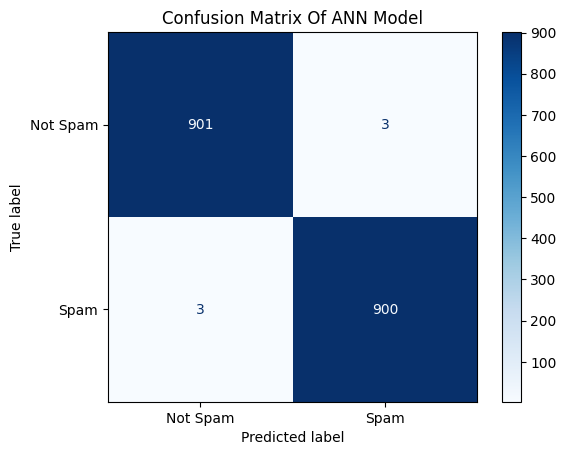

In [ ]:
cm = confusion_matrix(y_test, y_pred)
# Initialize the display using the calculated matrix
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=['Not Spam', 'Spam']
)

# Plot the matrix
disp.plot(cmap=plt.cm.Blues) 

# Add a title and show the plot
plt.title('Confusion Matrix Of ANN Model')
plt.show()

In [452]:
new_emails = [
    # --- Example Ham (Non-Spam) Messages ---
    "Regarding the team meeting scheduled for tomorrow, please review the attached document before 10 AM. Agenda is collaboration status.",
    "Can you confirm receipt of the invoice #90123? We need payment processed by the end of the week. Thanks!",
    "Just checking in on the project deadline. Are we still on track for the July 15th release? Let me know if you need anything.",
    
    # --- Example Spam Messages ---
    "URGENT PRIZE NOTIFICATION!!! Click here NOW to claim your FREE MILLION DOLLARS! Limited time offer, ACT FAST: http://tinyurl.com/scam",
    "Dear valued member, YOUR ACCOUNT HAS BEEN SUSPENDED. Verify your details immediately to avoid deactivation via this link: http://phishing.net/login",
    "VIAGRA 80% OFF! Do not miss this CHANCE to get the best deal. Use code FREEBIE at checkout. GUARANTEED!!!",
    
    # --- Mixed/Tricky Message ---
    "Hello! I found a great deal on a new watch at Amazon. It's 50% off if you use this coupon code. I'll send the link separately." 
]
print(predict(bnb,new_emails))

[0 0 0 1 1 1 0]
